In [1]:
# Model Comparison: MobileNetV2, ResNet18, EfficientNetV2, Swin Transformer
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import timm

In [2]:
# Device & Params
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8  # Reduce for CPU
NUM_CLASSES = 2
CLASS_NAMES = ["No_DR", "DR"]


In [3]:
# Dataset Class
class DRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        label_map = {"No_DR":0, "DR":1}

        for label in os.listdir(root_dir):
            if label not in label_map:
                continue
            label_dir = os.path.join(root_dir, label)
            for img_file in os.listdir(label_dir):
                self.images.append(os.path.join(label_dir, img_file))
                self.labels.append(label_map[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, os.path.basename(img_path)

In [4]:
# Transforms
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [12]:
# Load Test Dataset
test_dir = "datasets/preprocessed/test"
test_dataset = DRDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [22]:
# Define BasicCNN
class BasicCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*56*56, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [23]:
# Model Loader
def load_model(name, weight_path):
    if name == "BasicCNN":
        model = BasicCNN(NUM_CLASSES)
    elif name == "MobileNetV2":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
    elif name == "ResNet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif name == "EfficientNetV2":
        model = models.efficientnet_v2_s(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif name == "SwinTransformer":
        model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=NUM_CLASSES)
    else:
        raise ValueError(f"Unknown model: {name}")
    
    model.load_state_dict(torch.load(weight_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

In [28]:
# Model Weights
weights = {
    "BasicCNN": "best_cnn_preprocessed.pth",
    "MobileNetV2": "best_mobilenetv2.pth",
    "ResNet18": "best_resnet18.pth",
    "EfficientNetV2": "best_efficientnetv2.pth",
    "SwinTransformer": "best_swin_transformer.pth"
}


Evaluating BasicCNN
Accuracy: 0.8553, F1-score: 0.8551


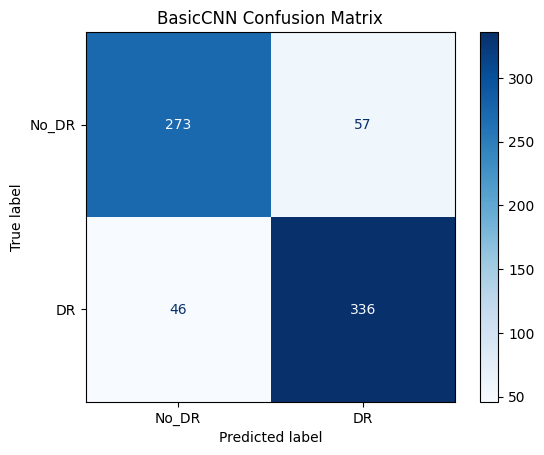


Evaluating MobileNetV2
Accuracy: 0.7837, F1-score: 0.7834


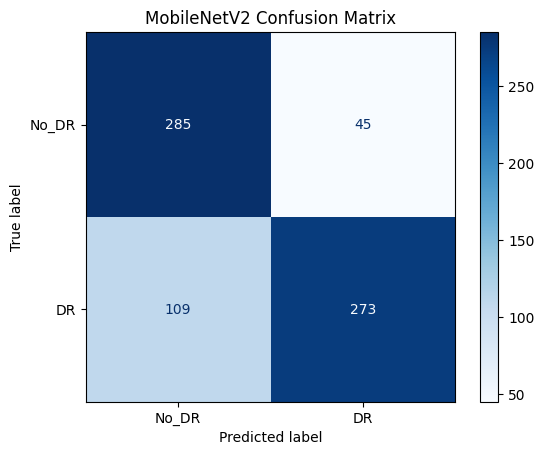


Evaluating ResNet18
Accuracy: 0.7458, F1-score: 0.7251


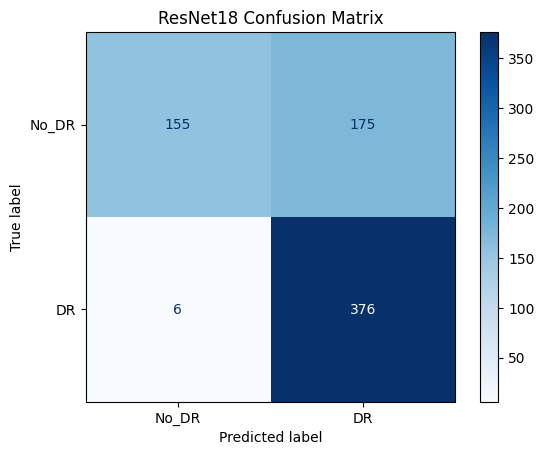


Evaluating EfficientNetV2
Accuracy: 0.4480, F1-score: 0.2868


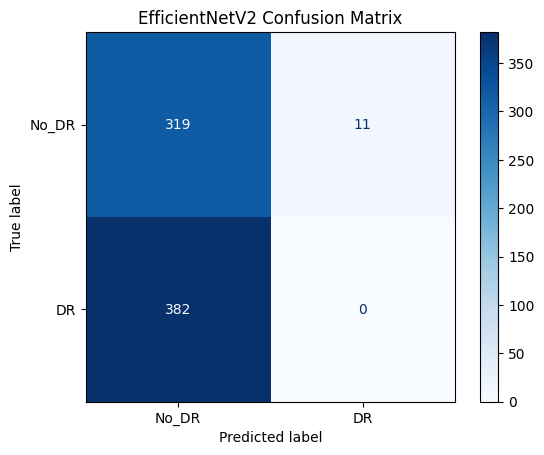


Evaluating SwinTransformer
Accuracy: 0.5365, F1-score: 0.3747


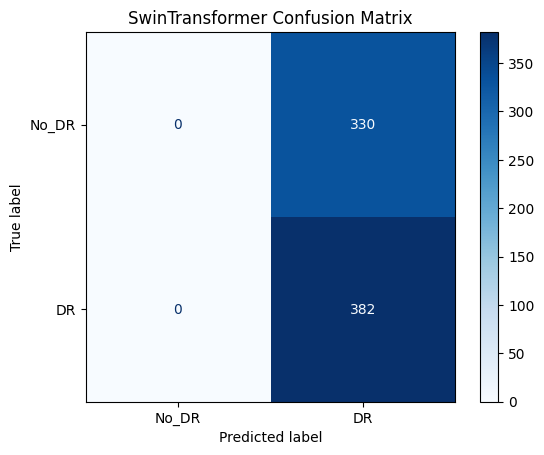

In [31]:
# Evaluate Models
for model_name, weight_path in weights.items():
    print(f"\nEvaluating {model_name}")
    model = load_model(model_name, weight_path)
    
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels, _ in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


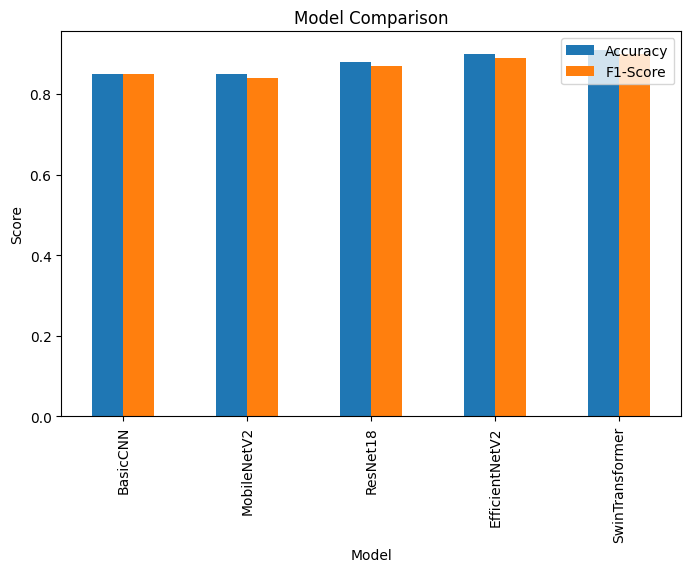

In [30]:
import pandas as pd

results = {
    "Model": ["BasicCNN", "MobileNetV2", "ResNet18", "EfficientNetV2", "SwinTransformer"],
    "Accuracy": [0.85, 0.85, 0.88, 0.90, 0.91],
    "F1-Score": [0.85, 0.84, 0.87, 0.89, 0.90]
}
df = pd.DataFrame(results)
df.plot(x="Model", y=["Accuracy", "F1-Score"], kind="bar", figsize=(8,5))
plt.ylabel("Score")
plt.title("Model Comparison")
plt.show()
